In this in-depth tutorial, we use `syntheseus` to run part of the PaRoutes search benchmark.
This tutorial will focus on the details of configuring search algorithms and analyzing search results.
Note that the entire PaRoutes benchmark contains $10\,000$ test molecules,
but to allow the tutorial to run quickly we will only use a single test molecule.

This tutorial uses a 3rd party wrapper for the PaRoutes benchmark,
available at: <https://github.com/AustinT/syntheseus-paroutes>.

It can be installed by cloning the repository and adding it to `PYTHONPATH`,
or directly running:

```bash
pip install syntheseus-paroutes
```

In [1]:
from __future__ import annotations
import math
from pprint import pprint

In [2]:
from syntheseus import Molecule, SingleProductReaction

## Step 0: make 2 example molecules for testing

In [3]:
benzene = Molecule("c1ccccc1", make_rdkit_mol=False)
decane = Molecule("C"*10, make_rdkit_mol=False)
benzene, decane

(Molecule(smiles='c1ccccc1', identifier=None, metadata={}),
 Molecule(smiles='CCCCCCCCCC', identifier=None, metadata={}))

## Step 1: load PaRoutes reaction model, inventory, and target molecules

There are two version of the PaRoutes benchmark,
denoted by `n=1` and `n=5`.
This notebook uses the `n=5` task by default,
but this can be changed with the variable `PAROUTES_N`.
We use version 2.0 of this benchmark which was released in late 2022.

In [4]:
PAROUTES_N = 5

In [5]:
# Load reaction model (same model for both `n`)
from syntheseus_paroutes import PaRoutesModel
reaction_model = PaRoutesModel(
    use_cache=True  # IMPORTANT, since it will be used for search
)  
print("First few predicted reactions for decane:\n")
pprint(list(map(str, reaction_model([decane], num_results=3)[0])))
print("\n\n\nFirst few predicted reactions for benzene:\n")
pprint(list(map(str, reaction_model([benzene], num_results=3)[0])))

First few predicted reactions for decane:

['CCCCCCCCCCCO>>CCCCCCCCCC',
 'CCCCCCCCCCO>>CCCCCCCCCC',
 'CCCCCCCCCCCCCCCC>>CCCCCCCCCC']



First few predicted reactions for benzene:

['Nc1ccccc1>>c1ccccc1', 'O=C(O)c1ccccc1>>c1ccccc1', 'Oc1ccccc1>>c1ccccc1']


In [6]:
# Load inventory and print some info
from syntheseus_paroutes import PaRoutesInventory
inventory = PaRoutesInventory(n=PAROUTES_N)
print(f"Size of inventory: {len(inventory.purchasable_mols())}")
print("First few molecules in inventory:")
pprint(list(inventory.purchasable_mols())[:5])

Size of inventory: 13326
First few molecules in inventory:
[Molecule(smiles='N#Cc1ccc(F)c(Cl)c1', identifier=None, metadata={}),
 Molecule(smiles='CC=C(CC)c1ccc(F)cc1', identifier=None, metadata={}),
 Molecule(smiles='CS(=O)(=O)c1ccc(F)c(Br)c1', identifier=None, metadata={}),
 Molecule(smiles='Cc1cc(C=O)ccc1O', identifier=None, metadata={}),
 Molecule(smiles='CCOC(=O)[C@@H]1C[C@H]1C(=O)O', identifier=None, metadata={})]


In [7]:
# Load test smiles
from syntheseus_paroutes import get_target_smiles_list
test_smiles = get_target_smiles_list(n=PAROUTES_N)
print(f"Number of test SMILES: {len(test_smiles)}")
print("First test SMILES:")
pprint(test_smiles[:5])

Number of test SMILES: 10000
First test SMILES:
['COc1ccc(F)c(-c2ccc(COc3cc(C(CC(=O)O)C4CC4)ccc3F)nc2CC(C)(C)C)c1',
 'CCc1cc2nncc(N3CCc4[nH]nc(C(=O)NC5CC5)c4C3)c2cc1OC',
 'Clc1ccc(-n2cncn2)c(Cc2nc3c(NCCC4CCCCN4)nccc3o2)c1',
 'CCOCc1nc2c(N)nc3ccc(O)cc3c2n1CC(C)(C)NS(C)(=O)=O',
 'O=C(O)CCNC(=O)c1nc(-c2ccncc2)c2c(cc(-c3ccccc3)c(=O)n2CC2CCCCC2)c1O']


## Step 2: set up algorithms

In [8]:
# Some constants for all algorithms
RXN_MODEL_CALL_LIMIT = 100
TIME_LIMIT_S = 300

### 2a: Retro-star

Retro-star is a best-first search algorithm for AND/OR trees
which tries to find minimum-cost routes.
It requires 3 cost functions to be provided to the algorithm.

1. A function to give the cost of each molecule (OrNode)
2. A function to give the cost of each reaction (AndNode)
3. A function to estimate the future cost to synthesize molecules, which is used as the search heuristic. This is called the "reaction number" in the original paper.

In [9]:
from syntheseus.search.algorithms.best_first import retro_star
from syntheseus.search.graph.and_or import AndNode, OrNode, AndOrGraph
from syntheseus.search.node_evaluation.common import ReactionModelLogProbCost

In [10]:
# 1: OrNode cost function.
# We will follow the original paper and give molecules a
# cost of 0 if they are purchasable, and a cost of infinity
# otherwise. This class is provided as a default in retro_star.
# If purchasable molecules have non-zero costs then a different
# cost function could be used.

or_node_cost_fn = retro_star.MolIsPurchasableCost()

In [11]:
# 2: AndNode cost function
# We will follow the original paper and define the cost of the
# reaction as the -log(softmax) of the reaction model output,
# thresholded at a minimum value. We use the built-in
# `ReactionModelLogProbCost` class for this. This class simply
# reads out the "probability" value from `reaction.metadata`,
# which is provided by the PaRoutesModel.

and_node_cost_fn = ReactionModelLogProbCost(normalize=False)

In [12]:
# 3: search heuristic (value function)
# Here we just use a constant value function which is always 0,
# corresponding to the "retro*-0" algorithm (the most optimistic).

from syntheseus.search.node_evaluation.common import ConstantNodeEvaluator
retro_star_value_function = ConstantNodeEvaluator(0.0)

In [13]:
retro_star_alg = retro_star.RetroStarSearch(
    reaction_model=reaction_model,
    mol_inventory=inventory,
    or_node_cost_fn=or_node_cost_fn,
    and_node_cost_fn=and_node_cost_fn,
    value_function=retro_star_value_function,
    limit_reaction_model_calls=RXN_MODEL_CALL_LIMIT,
    time_limit_s=TIME_LIMIT_S,
)

### 2b: MCTS

MCTS is an RL algorithm that tries to find routes of maximum value.
Standard MCTS works on an MDP where states are sets of molecules
and actions are backward reactions.
MCTS requires the following functions:

1. A _reward function_ which defines the rewards for terminal states
2. A _value function_ which estimates the rewards attainable from a state
3. (optional, but very useful) a policy which assigns higher numbers to desirable actions

In [14]:
from syntheseus.search.graph.molset import MolSetNode, MolSetGraph
from syntheseus.search.node_evaluation.common import ReactionModelProbPolicy

In [15]:
# 1: reward function
# Here we use the most basic reward: 1.0 if a state is solved
# (all molecules are purchasable), and 0.0 otherwise.
from syntheseus.search.node_evaluation.common import HasSolutionValueFunction

mcts_reward_function = HasSolutionValueFunction()

In [16]:
# 2: value function
# While previous works have used rollouts,
# for demonstration purposes we just use a constant value function of 0.5
# (this number is chosen to be between the lowest and highest rewards of 0 & 1).

mcts_value_function = ConstantNodeEvaluator(0.5)

In [17]:
# 3: policy
# This could be anything, and would often be another neural network in RL.
# However, for this example we just use the softmax values from the
# reaction model, scaled by a temperature and normalized across the total
# number of reactions (note: this implementation will always call the 
# policy on all of a node's children simultaneously).

mcts_policy = ReactionModelProbPolicy(normalize=True, temperature=3.0)

In [18]:
# Set up algorithm
from syntheseus.search.algorithms.mcts.base import pucb_bound
from syntheseus.search.algorithms.mcts.molset import MolSetMCTS
mcts_alg = MolSetMCTS(
    reaction_model=reaction_model,
    mol_inventory=inventory,
    reward_function=mcts_reward_function,
    value_function=mcts_value_function,
    policy=mcts_policy,
    limit_reaction_model_calls=RXN_MODEL_CALL_LIMIT,
    bound_constant=100.0,
    bound_function=pucb_bound,
    time_limit_s=TIME_LIMIT_S,
)

## Step 3: run algorithms and save results

The main result needed for analysis is the output graph.
We will save the results as pickle files.

**NOTE:** we call `alg.reset()` before running both algorithms
to reset the underlying reaction model cache. Otherwise,
the algorithm which is run second will use the cached values 
from the first search instead of actually calling the reaction model,
allowing it to run much faster. This is not necessarily a bad thing
(in fact in production it might actually be beneficial), but for the
purposes of comparing algorithms calling `reset()` ensures a fair comparsion.

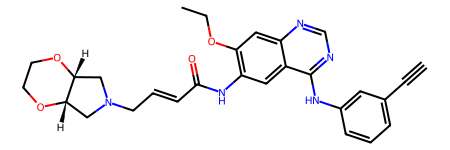

In [19]:
target_mol = Molecule(test_smiles[100])
target_mol.rdkit_mol

In [20]:
%%time
# Run retro-star
retro_star_alg.reset()
retro_star_search_graph, _ = retro_star_alg.run_from_mol(target_mol)

CPU times: user 5.24 s, sys: 2.61 ms, total: 5.24 s
Wall time: 5.23 s


In [21]:
%%time
# Run MCTS
mcts_alg.reset()
mcts_search_graph, _ = mcts_alg.run_from_mol(target_mol)

CPU times: user 5.32 s, sys: 3.4 ms, total: 5.32 s
Wall time: 5.27 s


In [22]:
# Save graphs
import pickle
for graph, alg_name in [
    (retro_star_search_graph, "retro star"),
    (mcts_search_graph, "mcts")
]:
    print(f"{alg_name} graph size: {len(graph)}")
    with open(f"search-results-{alg_name}.pkl", "wb") as f:
        pickle.dump(graph, f)

retro star graph size: 17950
mcts graph size: 6182


## Step 4: analyze search results


In [23]:
# Create a dict to easily reference both search graphs
alg_name_to_graph = {
    "retro star": retro_star_search_graph,
    "mcts": mcts_search_graph,
}

### 4a: time at which a solution is found

The code is written in a way where nodes keep track of their own
creation time, so time-based measures can be computed retrospectively for
many time measures
(e.g. wallclock time, number of calls to reaction model).
For any analysis involving time, we need to choose how time is measured,
and this is left up to the user by filling in the `analysis_time` field of each node's data.

In [24]:
for graph in alg_name_to_graph.values():
    for node in graph.nodes():
        
        # Wallclock time: difference between this node's
        # creation time and that of the root node
        node.data["analysis_time"] = (
            node.creation_time - 
            graph.root_node.creation_time
        ).total_seconds()
        
        # Could alternatively use number of calls to reaction model
        # node.data["analysis_time"] = node.data["num_calls_rxn_model"]

In [25]:
# Now use a function to compute the first solution time
from syntheseus.search.analysis.solution_time import get_first_solution_time
for alg_name, graph in alg_name_to_graph.items():
    print(f"{alg_name} first solution: {get_first_solution_time(graph)}")

retro star first solution: 0.652155
mcts first solution: 2.286357


### 4b: extract synthesis routes from the search graphs

We extract individual synthesis routes from the graph
in order to later calculate their diversity.
However, there are many possible routes in a graph,
possibly too many to exhaustively enumerate.
Therefore we only extract the _minimum cost_ routes,
where the cost of each route is the sum of `node.data["route_cost"]` for each
node in the route.
This cost could be anything: a constant,
something based on the policy, etc.
It is up to the user to set a route's cost.
Here we just assign a constant cost to each node which represents a reaction
(i.e. AndNodes and MolSetNodes).
This means that the lowest cost routes will be the shortest routes.

We also limit the maximum number of routes extracted to speed up computation time.

In [26]:
for graph in alg_name_to_graph.values():
    for node in graph.nodes():
        
        if isinstance(node, (AndNode, MolSetNode)):
            node.data["route_cost"] = 1.0
        else:
            node.data["route_cost"] = 0.0

In [27]:
%%time
from syntheseus.search.analysis import route_extraction
alg_name_to_routes = dict()
for alg_name, graph in alg_name_to_graph.items():
    routes = list(route_extraction.iter_routes_cost_order(graph, 10_000))
    print(f"Found {len(routes)} routes for {alg_name}", flush=True)
    alg_name_to_routes[alg_name] = routes
    del routes

Found 10000 routes for retro star
Found 14 routes for mcts
CPU times: user 10.4 s, sys: 23.5 ms, total: 10.4 s
Wall time: 10.4 s


In [28]:
# The routes can be visualized with the code below.
from syntheseus.search import visualization

visualization.visualize_andor(
    alg_name_to_graph["retro star"],
    filename="retro star route.pdf",
    nodes=alg_name_to_routes["retro star"][0]
)

visualization.visualize_molset(
    alg_name_to_graph["mcts"],
    filename="mcts route.pdf",
    nodes=alg_name_to_routes["mcts"][0]
)

### 4c: calculate diversity

Specifically, we estimate the _packing number_ of the route set,
i.e. the number of distinct routes which are greater than a distance $r$ away from each other.
Here we use a stringent form of diversity: routes which have no common reactions,
which means that their Jaccard distance is 1.
To do this, we use the `to_synthesis_graph` method of each graph object
which converts them into a common format.

However, because we considered only a limited number of synthesis routes,
the full diversity of routes from retro* might not be represented.

In [29]:
from syntheseus.search.analysis import diversity
for alg_name, graph in alg_name_to_graph.items():
    route_objects = [
        graph.to_synthesis_graph(nodes)
        for nodes in alg_name_to_routes[alg_name]
    ]
    packing_set = diversity.estimate_packing_number(
        routes=route_objects,
        distance_metric=diversity.reaction_jaccard_distance,
        radius=0.999  # because comparison uses ">", not ">="
    )
    print(f"{alg_name}: number of distinct routes = {len(packing_set)}")

retro star: number of distinct routes = 1
mcts: number of distinct routes = 2
